In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import glob as glob
from matplotlib.colors import LogNorm, Normalize

In [2]:
#### set directories and import files 
WRK = '/workdir/users/pd378/oil_international/sequence_processing/commensal_oil_run1.0/'
OIL_RESULTS=WRK+"s4_compile_tables/reduced_compiled_oil_results.txt"

sixteen_S_directory='/workdir/users/pd378/oil_international/sequence_processing/commensal_16S_run1.1/'
ribo_meta_tab=pd.read_csv("/workdir/users/pd378/oil_international/sequence_processing/commensal_16S_run1.1/metadata/metadata.txt", sep='\t')
ribo_meta_tab["full_sample"]=ribo_meta_tab["country"]+"_"+ribo_meta_tab["sample"]

OUT_TABS=WRK+"s5_analysis/publication_tabs/"
OUT_FIGS=WRK+"s5_analysis/figures/"

oil_result_tab=pd.read_csv(OIL_RESULTS, sep='\t')

#### Import and count the reads for each ASV sequence
* ribo size is the number of reads for each asv from the 16S
* ribo total is the total 16S reads
* ribo percent is the relative abundance of each asv

In [3]:
## parse out the relative abundance for each asv from the 16S sequencing 
community_files=glob.glob(sixteen_S_directory+"s2_filter_uniques/*_unique.fa")
uniq_list=[]
for fasta in community_files:
    for record in SeqIO.parse(fasta, "fasta"):
        file=record.id.split("__")[0]
        uniq=record.id.split("__")[1].split(";")[0]
        size=record.id.split(";")[1].strip("size=")
        seq=str(record.seq)
        uniq_list.append([file,uniq,size,seq])

### combine  the data into a table with the metadata
commuity_uniq=pd.DataFrame(uniq_list, columns=["file","ribo_uniq","ribo_size","ribo_seq"])       
commuity_uniq=pd.merge(left=ribo_meta_tab, right=commuity_uniq, on="file", how='right')
# calculate some stats on the 16S
commuity_uniq["ribo_size"]=commuity_uniq["ribo_size"].astype('int')
commuity_uniq["ribo_total"]=commuity_uniq.groupby("file")["ribo_size"].transform('sum')
commuity_uniq["ribo_percent"]=100*commuity_uniq["ribo_size"]/commuity_uniq["ribo_total"]

ERROR! Session/line number was not unique in database. History logging moved to new session 157


#### Combine the 16S sequnce counts with the OIL results by merging on the actual sequence
* oil_total_reads, otu_total_reads, and target_total_reads are all counts from the OIL PCR results

In [4]:
# merge 16S results with the oil results
cross_tab=pd.merge(left=oil_result_tab, right=commuity_uniq[["full_sample","ribo_uniq","ribo_size","ribo_seq","ribo_total"]], on=["full_sample","ribo_seq"], how="left", suffixes=["_oil","_16s"])
cross_tab["rASV_by_tASV_percent"]=100*cross_tab["rASV_by_tASV_total"]/cross_tab["target_total_reads"]
cross_tab["percent_ribo"]=100*cross_tab["ribo_size"]/cross_tab["ribo_total"]
#cross_tab["percent_target_asv"]=100*cross_tab["target_asv_total_reads"]/cross_tab["target_total_reads"]
cross_tab["fam_gen"]=cross_tab["family"]+"_"+cross_tab["genus"]


print(str(len(oil_result_tab))+" total interactinos from the OIL results")
print(str(len(cross_tab))+" interactions remain after merging the 16S sequencing results")
print(str(len(oil_result_tab)-len(cross_tab))+" interactions lost")

#cross_tab.to_csv(OUT_TABS+"combined_oil_16S_results.txt",sep='\t', index=False)
cross_tab.head(2)

50836 total interactinos from the OIL results
50836 interactions remain after merging the 16S sequencing results
0 interactions lost


,file,num,exp,country,sample,sample_targets,rep,full_sample,target,ribo_seq,...,named_total_reads,named_percent_reads,target_percent_reads,otu_by_target_percent,ribo_uniq_16s,ribo_size,ribo_total,rASV_by_tASV_percent,percent_ribo,fam_gen
0,401-OIL-Hond-026_014-Cfi_Cep_Cbl-A,401,OIL,Hond,026_014,Cfi_Cep_Cbl,A,Hond_026_014,cfiA,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,...,37662,99.393012,99.989444,99.387734,uniq_10,446.0,45769.0,79.452597,0.974459,Bacteroidaceae_Bacteroides
1,401-OIL-Hond-026_014-Cfi_Cep_Cbl-A,401,OIL,Hond,026_014,Cfi_Cep_Cbl,A,Hond_026_014,cfiA,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,...,37662,99.393012,99.989444,99.387734,NaN,NaN,NaN,0.044869,NaN,Bacteroidaceae_Bacteroides


### Plot broad results for all the samples

In [5]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt


### function that will return an axis that can then be used in a subplot
def plot_clustered_stacked2(dfall, labels=None, title="multiple stacked bar plot", y_label="", axe=None, style='default', legend=True):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    
    if axe is None:
        axe = plt.gca()
    
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    plt.style.use(style)
    plt.rcParams['svg.fonttype'] = 'none'


    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False)

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 90)
    axe.set_title(title)
    axe.set_ylabel(y_label)

    if legend:
        # Add invisible data to add another legend
        n=[]        
        l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
        if labels is not None:
            l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
        axe.add_artist(l1)
    
    return axe

def make_graph_list(df):
    tick_vals=pd.DataFrame(index=df.index.get_level_values(1).drop_duplicates())
    g_list=[]
    reps=["A","B","C"]
    for rep in reps:
        rep_tab=df.loc[rep]
        rep_tab=pd.merge(left=tick_vals, right=rep_tab, left_index=True, right_index=True, how='outer').fillna(0)
        g_list.append(rep_tab)
    return g_list

def make_graph_list2(df, samples):
    tick_vals=pd.DataFrame(index=samples)
  #  tick_vals=
    g_list=[]
    reps=["A","B","C"]
    for rep in reps:
        rep_tab=df.loc[rep]
        rep_tab=pd.merge(left=tick_vals, right=rep_tab, left_index=True, right_index=True, how='outer').fillna(0)
        g_list.append(rep_tab)
    return g_list

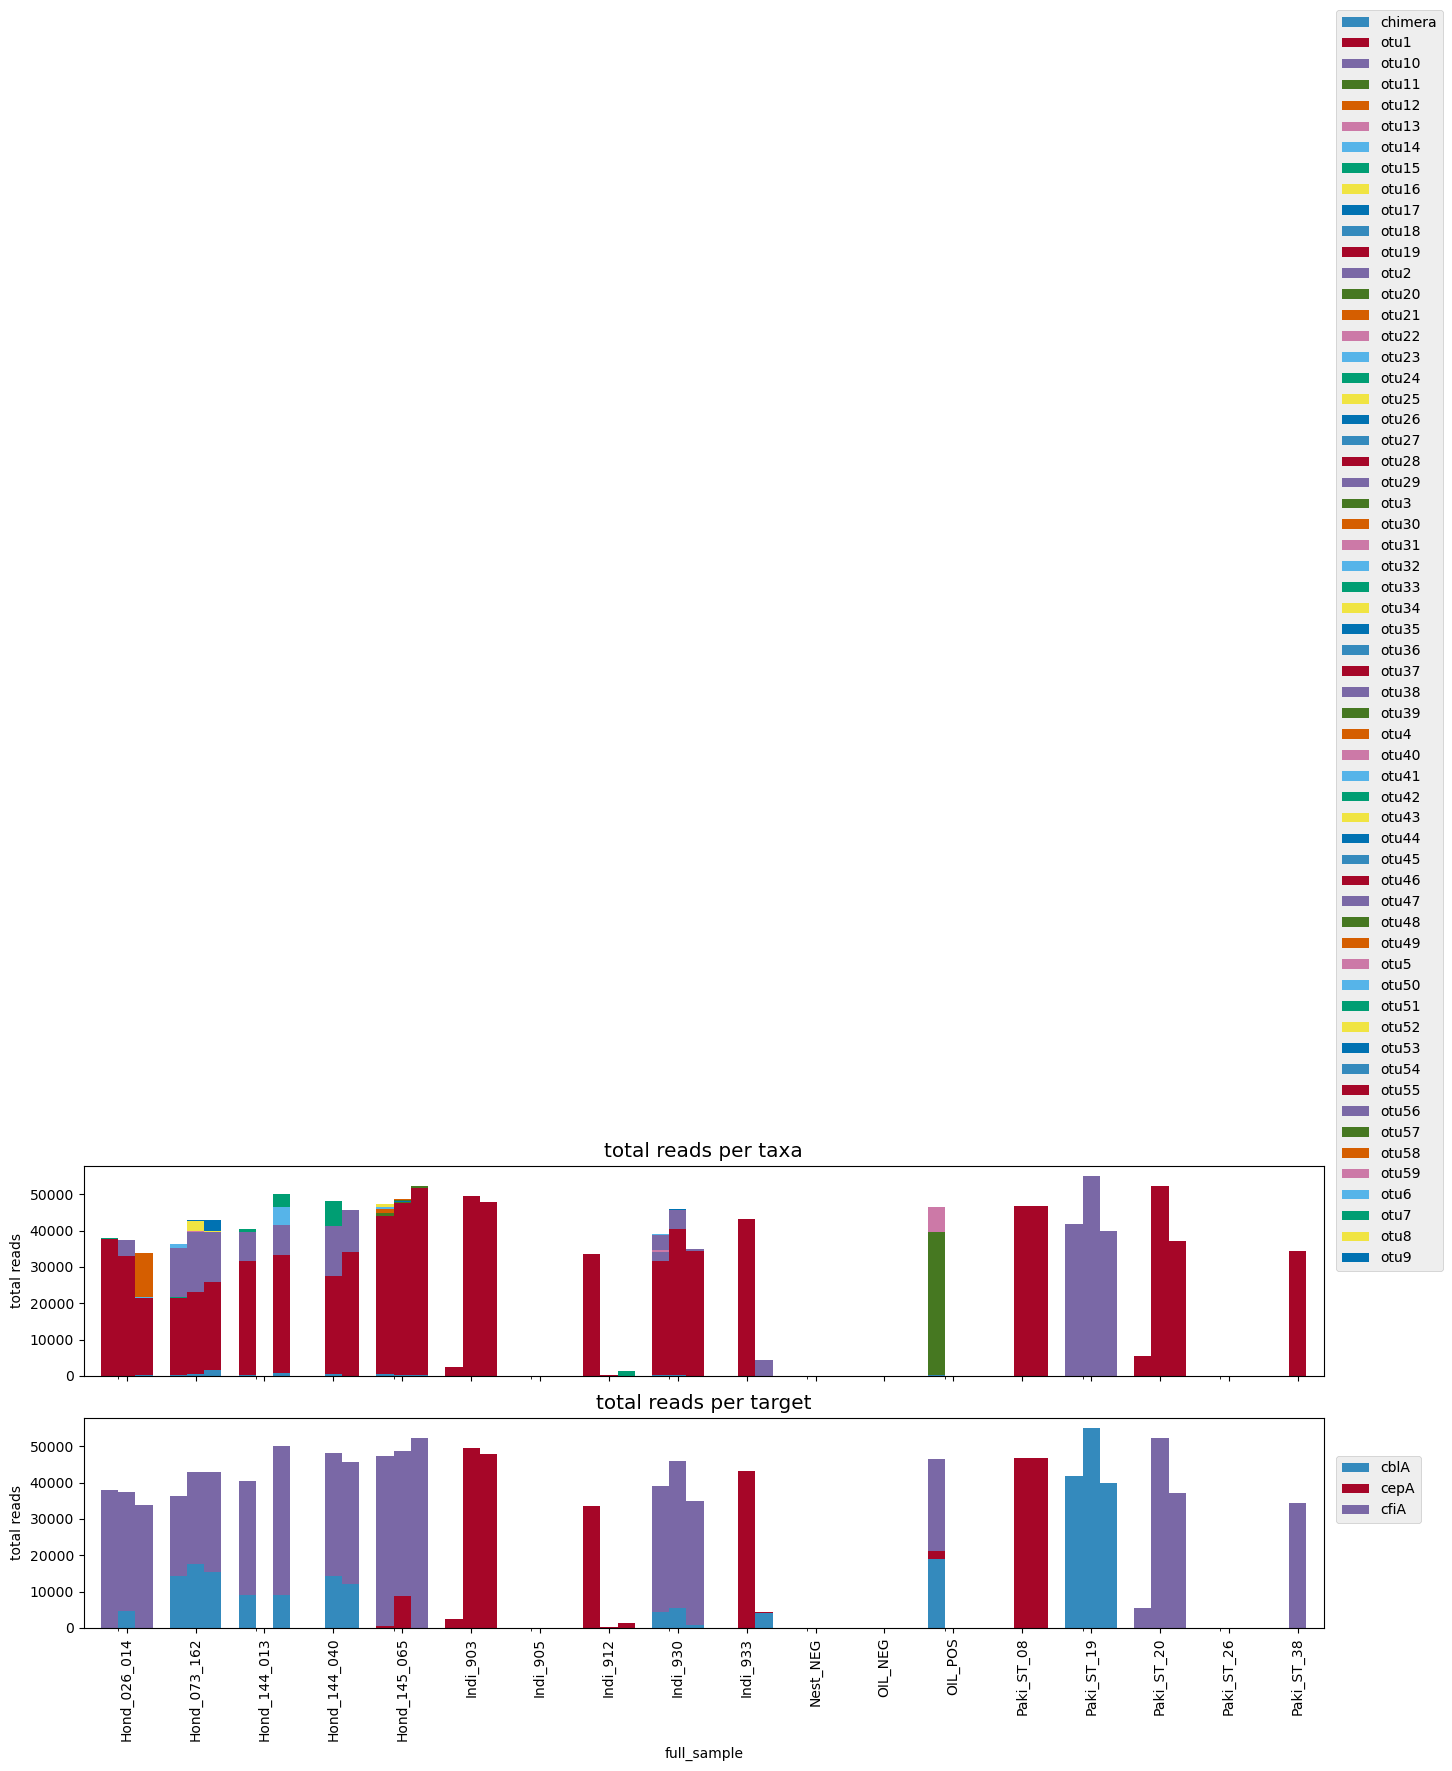

In [6]:
fig, ax = plt.subplots(2, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2]})

graph_tab=cross_tab.drop_duplicates(["file","otu"])
graph_tab=pd.pivot_table(graph_tab, values='otu_total_reads', index=["rep","full_sample"], columns=['otu']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[0] = plot_clustered_stacked2(g_list, title="total reads per taxa", y_label="total reads", axe=ax[0], style="bmh")

graph_tab=cross_tab.drop_duplicates(["file","target"])
graph_tab=pd.pivot_table(graph_tab, values='target_total_reads', index=["rep","full_sample"], columns=['target']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[1] = plot_clustered_stacked2(g_list, title="total reads per target", y_label="total reads", axe=ax[1], style="bmh")

#plt.savefig(OUT_FIGS+"seq_summary_figs/total_reads_per_taxa_all_samples.svg", format='svg')

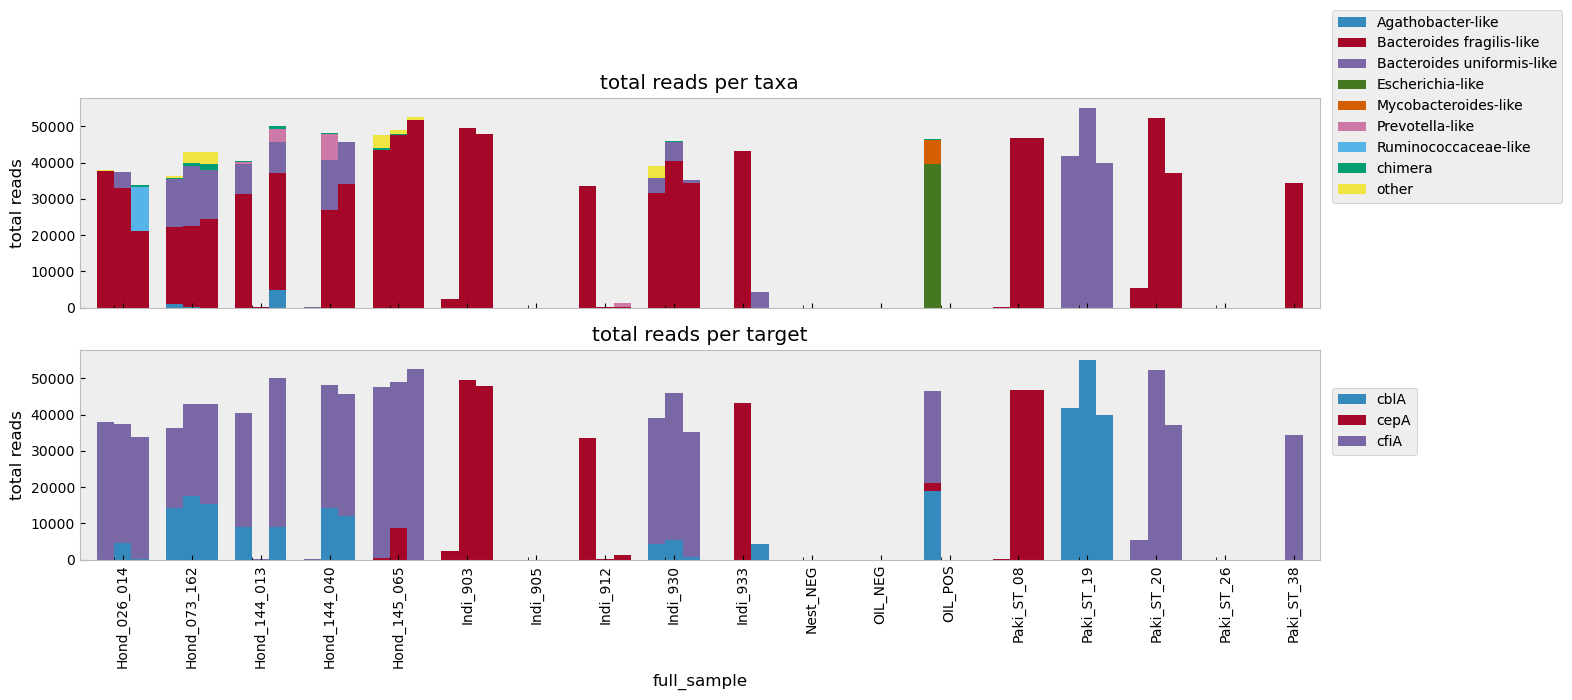

In [7]:
fig, ax = plt.subplots(2, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2]})

graph_tab=cross_tab.drop_duplicates(["file","named_taxa"])
graph_tab=pd.pivot_table(graph_tab, values='named_total_reads', index=["rep","full_sample"], columns=['named_taxa']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[0] = plot_clustered_stacked2(g_list, title="total reads per taxa", y_label="total reads", axe=ax[0], style="bmh")

graph_tab=cross_tab.drop_duplicates(["file","target"])
graph_tab=pd.pivot_table(graph_tab, values='target_total_reads', index=["rep","full_sample"], columns=['target']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[1] = plot_clustered_stacked2(g_list, title="total reads per target", y_label="total reads", axe=ax[1], style="bmh")

#plt.savefig(OUT_FIGS+"seq_summary_figs/total_reads_per_taxa_all_samples.svg", format='svg')

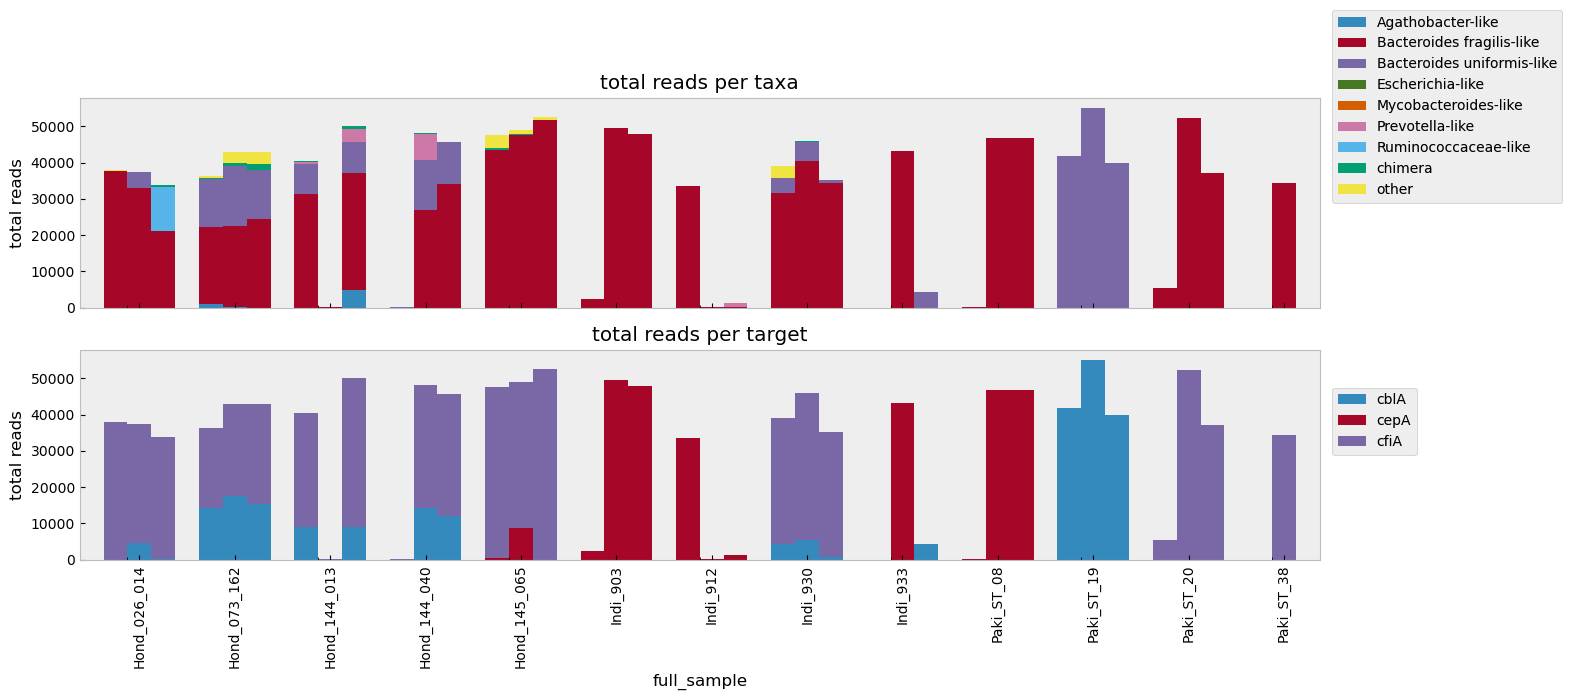

In [8]:
drop_list=["Nest_NEG","OIL_NEG","OIL_POS","Indi_905","Paki_ST_26"]
drop_tab=cross_tab[~cross_tab["full_sample"].isin(drop_list)]

fig, ax = plt.subplots(2, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2]})

graph_tab=drop_tab.drop_duplicates(["file","named_taxa"])
graph_tab=pd.pivot_table(graph_tab, values='named_total_reads', index=["rep","full_sample"], columns=['named_taxa']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[0] = plot_clustered_stacked2(g_list, title="total reads per taxa", y_label="total reads", axe=ax[0], style="bmh")

graph_tab=drop_tab.drop_duplicates(["file","target"])
graph_tab=pd.pivot_table(graph_tab, values='target_total_reads', index=["rep","full_sample"], columns=['target']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[1] = plot_clustered_stacked2(g_list, title="total reads per target", y_label="total reads", axe=ax[1], style="bmh")

#plt.savefig(OUT_FIGS+"seq_summary_figs/total_reads_per_taxa_dropped_samples.svg", format='svg')

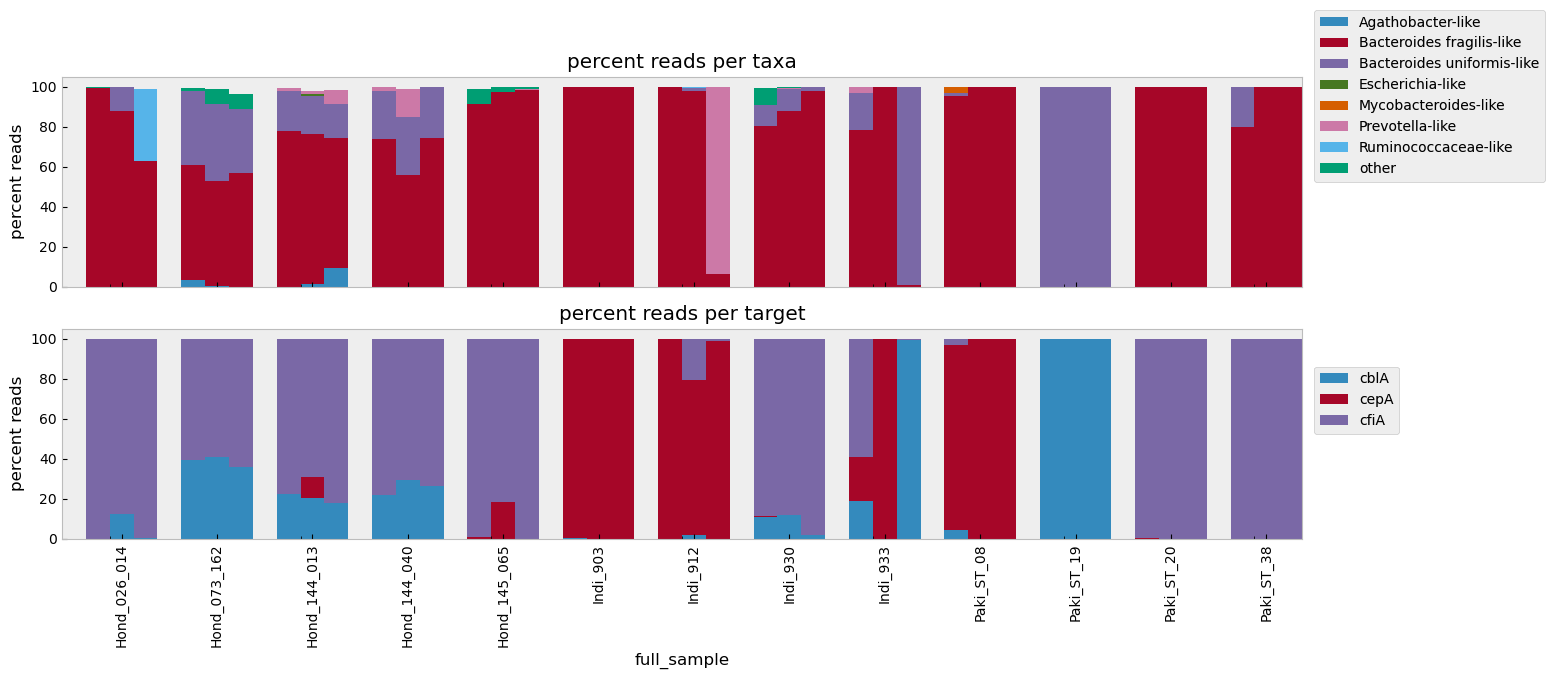

In [9]:
drop_tab_2=drop_tab[drop_tab["otu"]!='chimera']

fig, ax = plt.subplots(2, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2]})

graph_tab=drop_tab_2.drop_duplicates(["file","named_taxa"])
graph_tab=pd.pivot_table(graph_tab, values='named_percent_reads', index=["rep","full_sample"], columns=['named_taxa']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[0] = plot_clustered_stacked2(g_list, title="percent reads per taxa", y_label="percent reads", axe=ax[0], style="bmh")

graph_tab=drop_tab_2.drop_duplicates(["file","target"])
graph_tab=pd.pivot_table(graph_tab, values='target_percent_reads', index=["rep","full_sample"], columns=['target']).fillna(0)
g_list=make_graph_list(graph_tab)
ax[1] = plot_clustered_stacked2(g_list, title="percent reads per target", y_label="percent reads", axe=ax[1], style="bmh")

#plt.savefig(OUT_FIGS+"seq_summary_figs/percent_reads_per_taxa_dropped_samples.svg", format='svg')

### Plot results split by target

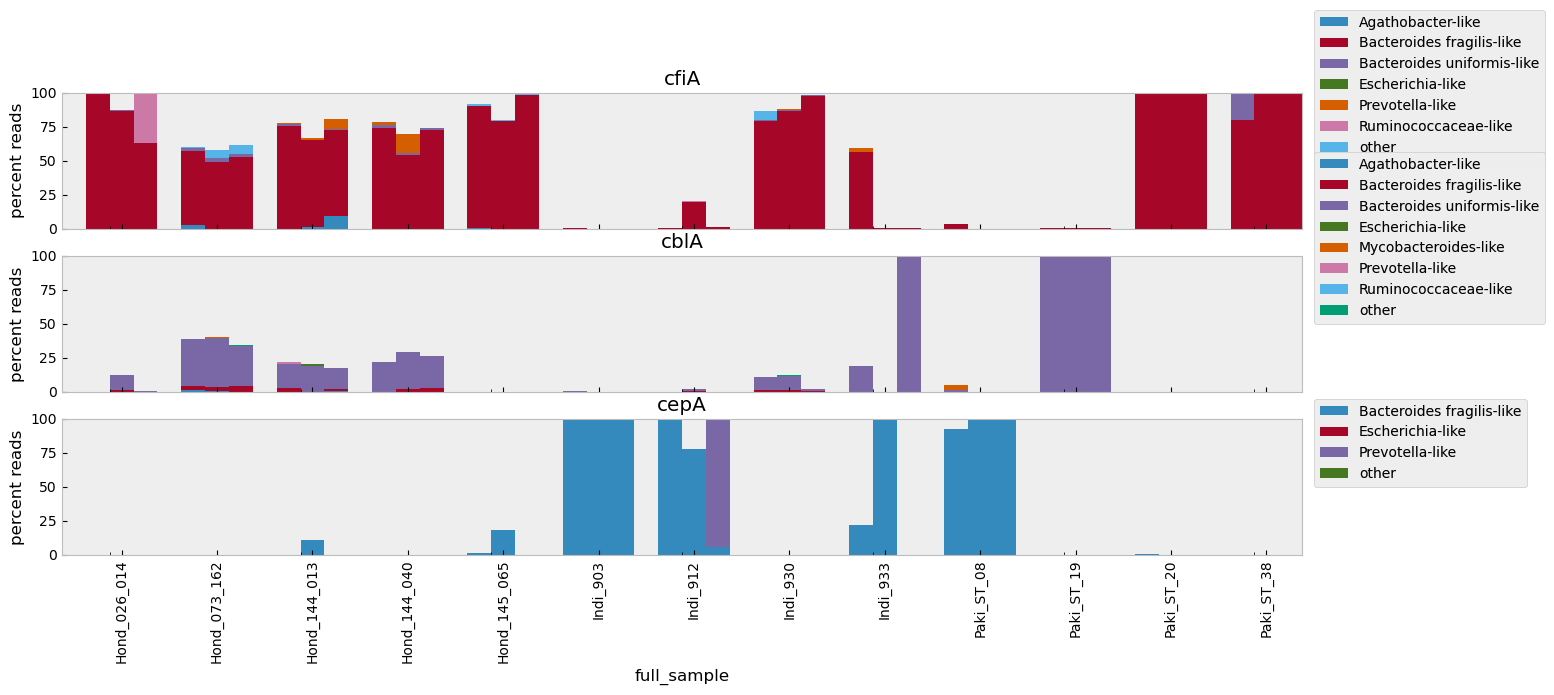

In [10]:
fig, ax = plt.subplots(3, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2,2]})

all_samples=drop_tab_2["full_sample"].drop_duplicates()
targets=["cfiA","cblA","cepA"]
for i in range (3):
    graph_tab=drop_tab_2[drop_tab_2["target"]==targets[i]]
    graph_tab=graph_tab.drop_duplicates(["file","named_taxa"])
    graph_tab=pd.pivot_table(graph_tab, values='otu_by_target_percent', index=["rep","full_sample"], columns=['named_taxa']).fillna(0)
    g_list=make_graph_list2(graph_tab, all_samples)
    ax[i] = plot_clustered_stacked2(g_list, title=targets[i], y_label="percent reads", axe=ax[i], style="bmh")
    ax[i].set_ylim([0, 100])

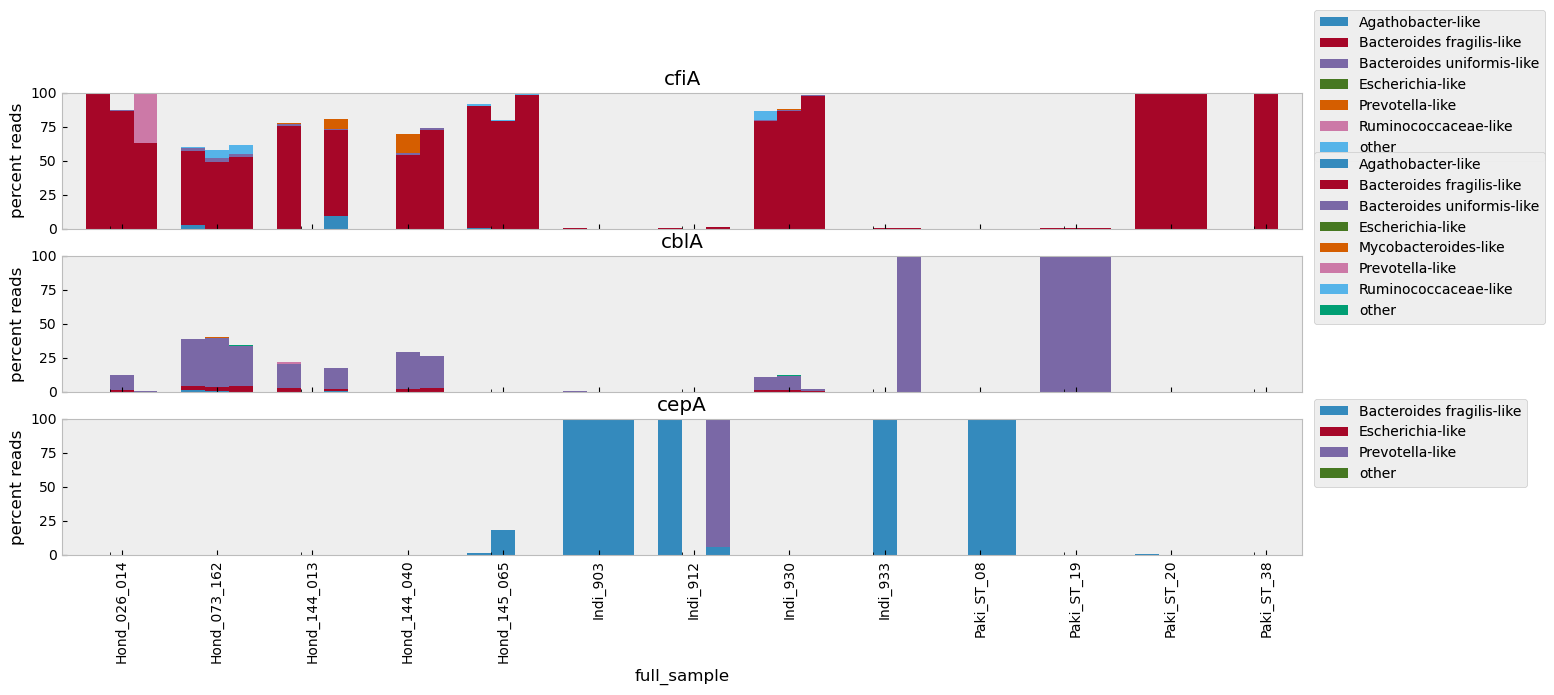

In [11]:
### filter out obviously bad sequencing
min_reads=500
drop_tab_3=drop_tab_2[drop_tab_2["oil_total_reads"] >= min_reads]

fig, ax = plt.subplots(3, figsize=(16,6), sharex='col', gridspec_kw={'height_ratios': [2,2,2]})

all_samples=drop_tab_3["full_sample"].drop_duplicates()
targets=["cfiA","cblA","cepA"]
for i in range (3):
    graph_tab=drop_tab_3[drop_tab_3["target"]==targets[i]]
    graph_tab=graph_tab.drop_duplicates(["file","named_taxa"])
    graph_tab=pd.pivot_table(graph_tab, values='otu_by_target_percent', index=["rep","full_sample"], columns=['named_taxa']).fillna(0)
    g_list=make_graph_list2(graph_tab, all_samples)
    ax[i] = plot_clustered_stacked2(g_list, title=targets[i], y_label="percent reads", axe=ax[i], style="bmh")
    ax[i].set_ylim([0, 100])

In [12]:
#drop_tab_3["full_sample"].drop_duplicates().to_list()
#
#rep_dict={'Hond_16_013':3,'Hond_16_024':3,'Hond_62_016':3,'Hond_62_082':3,'Hond_62_137':3,
#          'Hond_62_144':2,'Indi_901':6,'Indi_903':3,'Indi_912':3,'Indi_920':3,'Indi_928':6,
#          'Viet_VH31':2,'Viet_VH33':3,'Viet_VH32':3,'Viet_VH35':2,'Viet_VH41':3,'Viet_VH42':2,
#          'Paki_ST_19':3,'Paki_ST_26':2,'Paki_ST_29':2,'Paki_ST_40':2,'Paki_ST_47':2}

## Next step is the ASV analysis

In [13]:
#### I need to export the important ASV sequences to run CD-HIT and cluster them into smaller catagories

# filter out reads below the threshold as they are likely noise
read_threshold=10
drop_tab_3["rASV_percent_reads"]=100*drop_tab_3["rASV_total_reads"]/drop_tab_3["oil_total_reads"]      
drop_tab_3["tASV_percent_reads"]=100*drop_tab_3["tASV_total_reads"]/drop_tab_3["oil_total_reads"]
rASV_assign_tab=drop_tab_3[drop_tab_3["rASV_total_reads"] >= read_threshold].sort_values(["rASV_percent_reads"],ascending=False).drop_duplicates(["ribo_seq"])
tASV_assign_tab=drop_tab_3[drop_tab_3["tASV_total_reads"] >= read_threshold].sort_values(["tASV_percent_reads"],ascending=False).drop_duplicates(["target_seq"])

# Provide an arbitary name for each of the ASV sequence varients 
ribo_key_list=[]
ribo_records=[]
for name, group in rASV_assign_tab.groupby(["named_taxa"]):
    #group=group.drop_duplicates("ribo_seq")
    seq_count=len(group)
    int_names=["{0:03}".format(i) for i in range(1, seq_count+1)]
    seqs=group["ribo_seq"].to_list()
    for i in range(seq_count):
        seq_name=name+"-"+str(int_names[i])
        ribo_key_list.append([seqs[i], seq_name])
        ribo_records.append(SeqRecord(Seq(seqs[i]),id=seq_name, description=""))
ribo_key_df=pd.DataFrame(ribo_key_list, columns=["ribo_seq", "ribo_asv"])

# same but for the targets
target_key_list=[]
target_records=[]
target_split_keys=[[] for x in range(3)]
j=0
for name, group in tASV_assign_tab.groupby(["target"]):
    #group=group.drop_duplicates("target_seq")
    seq_count=len(group.index)
    int_names=["{0:03}".format(i) for i in range(1, seq_count+1)]
    seqs=group["target_seq"].to_list()
    for i in range(seq_count):
        seq_name=name+"-"+str(int_names[i])
        target_key_list.append([seqs[i], seq_name])
        target_split_keys[j].append(seq_name)
        target_records.append(SeqRecord(Seq(seqs[i]), id=seq_name, description=""))
    j+=1    
target_key_df=pd.DataFrame(target_key_list, columns=["target_seq", "target_asv"])

# add the names to the rest of the data
asv_cross_tab=pd.merge(left=drop_tab_3, right=ribo_key_df, on="ribo_seq", how='left')
asv_cross_tab=pd.merge(left=asv_cross_tab, right=target_key_df, on="target_seq", how='left')
asv_cross_tab.head(3)


#with open(WRK+"s5_analysis/cd_hit/ribo_asv.fasta", "w") as output_handle:
#    SeqIO.write(ribo_records, output_handle, "fasta")
#with open(WRK+"s5_analysis/cd_hit/target_asv.fasta", "w") as output_handle:
#    SeqIO.write(target_records, output_handle, "fasta")

/home/pd378/miniconda3/envs/jupyter2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/pd378/miniconda3/envs/jupyter2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,file,num,exp,country,sample,sample_targets,rep,full_sample,target,ribo_seq,...,ribo_uniq_16s,ribo_size,ribo_total,rASV_by_tASV_percent,percent_ribo,fam_gen,rASV_percent_reads,tASV_percent_reads,ribo_asv,target_asv
0,401-OIL-Hond-026_014-Cfi_Cep_Cbl-A,401,OIL,Hond,026_014,Cfi_Cep_Cbl,A,Hond_026_014,cfiA,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,...,uniq_10,446.0,45769.0,79.452597,0.974459,Bacteroidaceae_Bacteroides,93.286182,85.184208,Bacteroides fragilis-like-001,cfiA-002
1,401-OIL-Hond-026_014-Cfi_Cep_Cbl-A,401,OIL,Hond,026_014,Cfi_Cep_Cbl,A,Hond_026_014,cfiA,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,...,NaN,NaN,NaN,0.044869,NaN,Bacteroidaceae_Bacteroides,0.050143,85.184208,Bacteroides fragilis-like-027,cfiA-002
2,401-OIL-Hond-026_014-Cfi_Cep_Cbl-A,401,OIL,Hond,026_014,Cfi_Cep_Cbl,A,Hond_026_014,cfiA,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,...,uniq_10,446.0,45769.0,0.010557,0.974459,Bacteroidaceae_Bacteroides,93.286182,0.013195,Bacteroides fragilis-like-001,NaN


## Run CD-HIT on the exported sequences with 99% identity (clustered 98% ID for target genes)
* /programs/cd-hit-4.8.1/cd-hit -i $FASTAS/ribo_asv.fasta -o $FASTAS/ribo_hit_99.fasta -c 0.99 -g 1 -bak 1 -d 100
* /programs/cd-hit-4.8.1/cd-hit -i $FASTAS/target_asv.fasta -o $FASTAS/target_hit_99.fasta -c 0.99 -g 1 -bak 1 -d 100

In [65]:
ribo_key_df.columns

Index(['ribo_seq', 'ribo_asv'], dtype='object')

In [14]:
# parse out the CD-HIT results and give arbitrary names to the clusters...thi probably makes naming the ASVs unecessary...
cd_ribo=pd.read_csv(WRK+"s5_analysis/cd_hit/ribo_hit_99.fasta.bak.clstr", sep="\t|>|\.\.\.", names=["rCluster","aa","ribo_asv","ID"])[["rCluster","ribo_asv"]]
cd_ribo["rCluster"]=cd_ribo["rCluster"]+1   #add 1 to start cluster names at 1 instead of 0
cd_ribo["rCluster"]="cluster_"+cd_ribo["rCluster"].astype('str') #now append a prefix to each cluster
#do the same for the targets
cd_target=pd.read_csv(WRK+"s5_analysis/cd_hit/target_hit_98.fasta.bak.clstr", sep="\t|>|\.\.\.", names=["tCluster","aa","target_asv","ID"])[["tCluster","target_asv"]]
cd_target["tCluster"]=cd_target["tCluster"]+1
cd_target["tCluster"]="cluster_"+cd_target["tCluster"].astype('str')

#merget the clustering info with the full dataset
clust_cross_tab=pd.merge(left=asv_cross_tab, right=cd_ribo, on="ribo_asv", how='left')
clust_cross_tab=pd.merge(left=clust_cross_tab, right=cd_target, on="target_asv", how='left')
#finally add information to give the culters meaning
clust_cross_tab["rCluster"]=clust_cross_tab["named_taxa"]+"_"+clust_cross_tab["rCluster"]
clust_cross_tab["tCluster"]=clust_cross_tab["target"]+"_"+clust_cross_tab["tCluster"]
# compile stas about the clusters
clust_cross_tab["rClust_total_reads"]=clust_cross_tab.groupby(["file","rCluster"])["rASV_total_reads"].transform('sum')
clust_cross_tab["tClust_total_reads"]=clust_cross_tab.groupby(["file","tCluster"])["tASV_total_reads"].transform('sum')
clust_cross_tab["rClust_by_tClust_total"]=clust_cross_tab.groupby(["file","tCluster","rCluster"])["rASV_by_tASV_total"].transform('sum')
clust_cross_tab["rClust_by_tClust_percent"]=100*clust_cross_tab["rClust_by_tClust_total"]/clust_cross_tab["target_total_reads"]
clust_cross_tab["rASV_by_tClust_total"]=clust_cross_tab.groupby(["file","tCluster","ribo_asv"])["rASV_by_tASV_total"].transform('sum')
clust_cross_tab["rASV_by_tClust_percent"]=100*clust_cross_tab["rASV_by_tClust_total"]/clust_cross_tab["target_total_reads"]

/home/pd378/miniconda3/envs/jupyter2/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


### Filter results based on passing a threshold across replicates
* I have to change this to two replicates now because so many of them failed

In [15]:
sample_rep_count=clust_cross_tab.drop_duplicates(["full_sample","rep"]).groupby("full_sample").size().reset_index(name="reps")
rep_dict=dict(zip(sample_rep_count.full_sample, sample_rep_count.reps))

In [16]:
#rep_dict={'Hond_16_013':3,'Hond_16_024':3,'Hond_62_016':3,'Hond_62_082':3,'Hond_62_137':3,
#          'Hond_62_144':2,'Indi_901':5,'Indi_903':3,'Indi_912':3,'Indi_920':3,'Indi_928':5,
#          'Viet_VH31':2,'Viet_VH33':3,'Viet_VH32':3,'Viet_VH35':2,'Viet_VH41':3,'Viet_VH42':2,
#          'Paki_ST_19':3,'Paki_ST_26':2,'Paki_ST_29':2,'Paki_ST_40':2,'Paki_ST_47':2}

#group and only keep hits that exist across three replicates
stats_tab=clust_cross_tab.drop_duplicates(["file","ribo_asv","tCluster"])
# need to have at least 100 reads for the association (may need to change)
stats_tab=stats_tab[stats_tab["rASV_by_tClust_total"] > 100]
stats_filtered=pd.DataFrame()

for name, group in stats_tab.groupby(['full_sample','ribo_asv','tCluster']):
    full_sample=name[0]
    if len(group) >= rep_dict[full_sample]:
        stats_filtered=stats_filtered.append(group)

print(str(len(clust_cross_tab))+" starting and "+str(len(stats_filtered))+" after filtering")
stats_filtered=stats_filtered.groupby(['full_sample','target','ribo_asv','tCluster'])["rASV_by_tClust_percent"].describe().reset_index()#  agg('mean').reset_index()
print(str(len(stats_filtered))+" averaged data_points")

45951 starting and 113 after filtering
47 averaged data_points


In [17]:
from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from matplotlib.patches import FancyBboxPatch

import warnings
warnings.filterwarnings('ignore')

filter_thresh=0.5
print(len(stats_filtered))
filter_tab=stats_filtered[stats_filtered["mean"] >= filter_thresh]
print(len(filter_tab))
ribos=filter_tab["ribo_asv"].sort_values().drop_duplicates().to_list()

all_samples=filter_tab["full_sample"].drop_duplicates().sort_values().to_list()

## generate color palettes for each target group
targets=["cfiA","cblA","cepA"]
color_cats={"cfiA":'rocket',"cblA":'mako',"cepA":'plasma'}
pallette_dict={}
for t in range(3):
    # get my list of target clusters
    target_clusters=filter_tab[filter_tab["target"]==targets[t]]
    target_clusters=target_clusters[["tCluster"]].drop_duplicates().sort_values("tCluster").reset_index()
    # make a pallette for the target gene
    this_pallette=sns.color_palette(color_cats[targets[t]], len(target_clusters)+1)
    f=1
    for cluster in target_clusters["tCluster"]:
        pallette_dict[cluster]=this_pallette[f]
        f+=1
    

47
40


In [43]:
def make_bar(sample, total=50):
    pos_color='red'
    neg_color='dimgrey'
    
    ### frag is 1, uni is 3
    the_colors = list(sns.color_palette('hls',5))
    all_colors = [the_colors[1]]*6 + [the_colors[3]]*3 + ['black']
    ribo_color_dict = dict(zip(ribos, all_colors))
    seq_2_asv_dict = dict(zip(ribo_key_df['ribo_seq'], ribo_key_df['ribo_asv']))
    
    # get the 16S results for this sample
    com_bars=commuity_uniq[commuity_uniq["full_sample"]==sample].sort_values("ribo_percent", ascending=False)
    # get the asv names
    ribo_sample=filter_tab[filter_tab["full_sample"]==sample]["ribo_asv"].drop_duplicates().to_list()
    # find the associated asv sequence
    ribo_asv_seqs=ribo_key_df[ribo_key_df["ribo_asv"].isin(ribo_sample)]["ribo_seq"].drop_duplicates().to_list()
    # take the top hits and combine with just the dedicated hits and remove duplicates and sort again
    plot_bars=com_bars.head(total).append(com_bars[com_bars["ribo_seq"].isin(ribo_asv_seqs)]).drop_duplicates().sort_values("ribo_percent")
    # assign colors for the interesting ones
    color=[]
    update_mean=[]
    max_per=plot_bars["ribo_percent"].max()
    for index, row in plot_bars.iterrows():
        seq=row["ribo_seq"]
        per=row["ribo_percent"]
        if seq in ribo_asv_seqs:
            asv_name = seq_2_asv_dict[seq]
            pos_color = ribo_color_dict[asv_name]
            color.append(pos_color)
            per=max_per
        else:
            color.append(neg_color)
        update_mean.append(per)
    plot_bars["colors"]=color  
    plot_bars["update_percent"]=update_mean 

    #### graph it
  #  g=plot_bars.plot(kind='bar',x='ribo_uniq', y='ribo_percent', color=plot_bars['colors'], width=1.0, ax=axes) 
   # g.set(xlabel=None)
   # g.set_yscale('log')
   # g.get_xaxis().set_ticks([])
                           
    return plot_bars

In [ ]:
### frag is 1, uni is 3
list(sns.color_palette('hls',5))

In [25]:
bf_colors=list(sns.color_palette("Blues_r",6))
bu_colors=list(sns.color_palette("YlOrBr_r",3))
pv_colors=list(sns.color_palette("RdPu_r",1))
all_colors=bf_colors + bu_colors + pv_colors
ribo_color_dict = dict(zip(ribos, all_colors))
seq_2_asv_dict = dict(zip(ribo_key_df['ribo_seq'], ribo_key_df['ribo_asv']))
ribos

['Bacteroides fragilis-like-001',
 'Bacteroides fragilis-like-002',
 'Bacteroides fragilis-like-003',
 'Bacteroides fragilis-like-007',
 'Bacteroides fragilis-like-012',
 'Bacteroides fragilis-like-016',
 'Bacteroides uniformis-like-001',
 'Bacteroides uniformis-like-002',
 'Bacteroides uniformis-like-003',
 'other-004']

In [37]:
### frag is 1, uni is 3
the_colors = list(sns.color_palette('hls',5))
all_colors = [the_colors[1]]*6 + [the_colors[3]]*3 + ['black']
ribo_color_dict = dict(zip(ribos, all_colors))
seq_2_asv_dict = dict(zip(ribo_key_df['ribo_seq'], ribo_key_df['ribo_asv']))

In [42]:
[the_colors[1]]*2

[(0.7247999999999999, 0.86, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997)]

In [36]:
sns.color_palette('hls',5)

[(0.86, 0.3712, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86)]

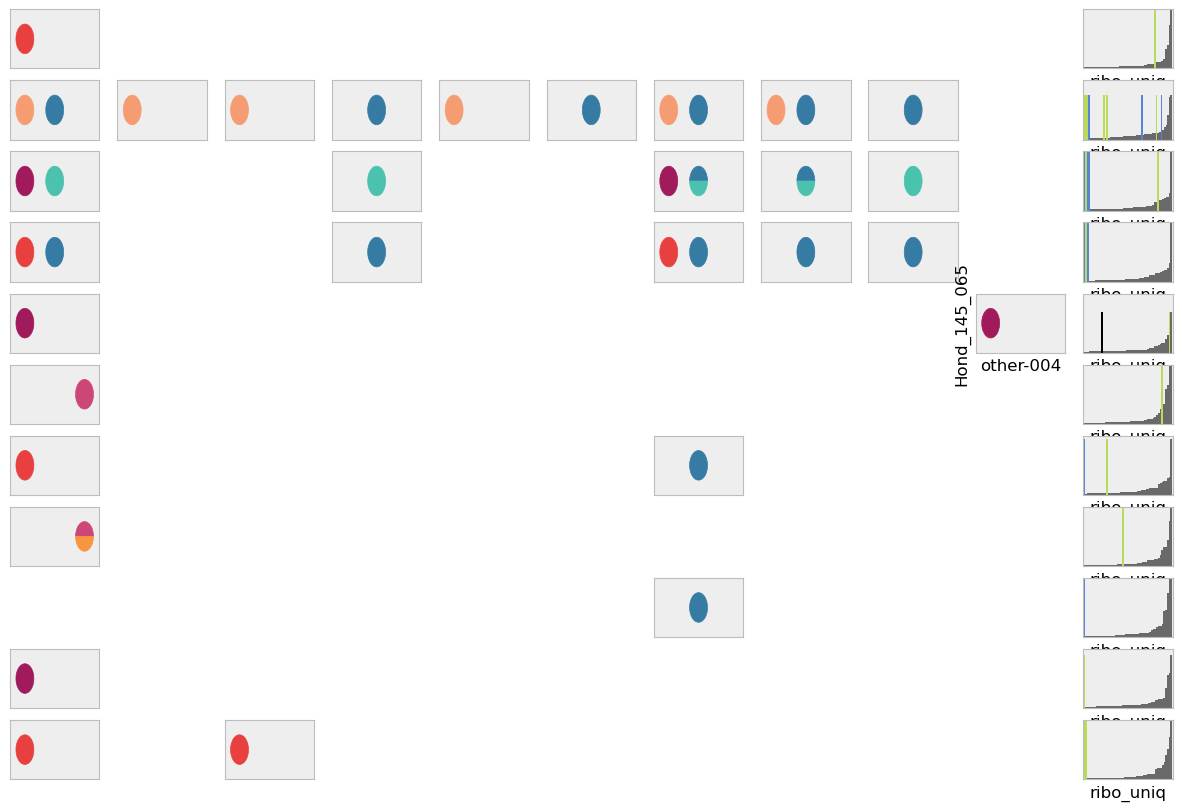

In [45]:


fig, axes = plt.subplots(len(all_samples),1+len(ribos), figsize=(15,10))#, sharey='row', sharex='col')
plt.rcParams['svg.fonttype']='none'

targets=["cfiA","cblA","cepA"]
#gene_index=pd.DataFrame(index=genes)

radius=0.3
y_size=1.2
y_lim=(0,y_size)
#all_samples=(0,count)
y_val=y_size/2



for i in range(len(ribos)):
    for j in range(len(all_samples)):
        g_tab=filter_tab[(filter_tab["ribo_asv"]==ribos[i]) & (filter_tab["full_sample"]==all_samples[j])]
   #     if (j==3) & (i==3):
   #         g_tab=dummy_frame
        if g_tab.empty:
            axes[j][i].axis('off')
            continue
            
     #   hits=g_tab["tCluster"].drop_duplicates()
        
        x_range=np.arange(0.5, 3)
        axes[j][i].set_xlim(0,3)
        axes[j][i].set_ylim(y_lim)
        axes[j][i].xaxis.grid(False)
        axes[j][i].yaxis.grid(False)
        axes[j][i].set_xticks([])
        axes[j][i].set_yticks([])
        
      #  axes[j][i].set_xlabel(ribos[i])
        # Set y-axis label
        #axes[j][i].set_ylabel(all_samples[j])
        
        
        
        #### plot the pies
        for x in range(3):  
            gene_tab=g_tab[g_tab["target"]==targets[x]]
            tClusters=gene_tab["tCluster"].drop_duplicates().sort_values().to_list()
            ### skip if there isn't anything
            if gene_tab.empty:
                continue
            
            
            arc=360/len(tClusters)
            start=0
            for k in range(len(tClusters)):
                axes[j][i].add_patch(Wedge((x_range[x], y_val), r=radius, theta1=start, theta2=start+arc, color=pallette_dict[tClusters[k]]))
                start+=arc
  

for j in range(len(all_samples)):
    
    plot_bars=make_bar(all_samples[j], 50)   
    if not plot_bars.empty:
        plot_bars.plot(kind='bar',x='ribo_uniq', y='update_percent', color=plot_bars['colors'], width=1.0, ax=axes[j][len(ribos)], legend=False)     
    else: print(all_samples[j])
     
    axes[j][len(ribos)].xaxis.grid(False)
    axes[j][len(ribos)].yaxis.grid(False)
#    axes[j][len(ribos)].set_yscale('log')###
    axes[j][len(ribos)].set_xticks([])
    axes[j][len(ribos)].set_yticks([])    
#    axes[j][len(ribos)].set_xlabel()###
#    axes[j][len(ribos)].set_ylabel()###
#    axes[j][i].set_xlim(0,10)###
    axes[j][len(ribos)].set_ylim(0,10)


    axes[j][i].set_xlabel(ribos[i])
    #Set y-axis label
    axes[j][i].set_ylabel(all_samples[j])
        

plt.savefig(OUT_FIGS+"oil_results_summary/commensal_color_bars_oil_summary.svg", format='svg')        


In [73]:
filter_tab["ribo_asv"].drop_duplicates()

0      Bacteroides fragilis-like-001
2      Bacteroides fragilis-like-007
3      Bacteroides fragilis-like-016
4     Bacteroides uniformis-like-001
5     Bacteroides uniformis-like-002
6     Bacteroides uniformis-like-003
9      Bacteroides fragilis-like-002
10     Bacteroides fragilis-like-003
11     Bacteroides fragilis-like-012
36                         other-004
Name: ribo_asv, dtype: object

In [148]:
all_samples

['Hond_026_014',
 'Hond_073_162',
 'Hond_144_013',
 'Hond_144_040',
 'Hond_145_065',
 'Indi_903',
 'Indi_930',
 'Paki_ST_08',
 'Paki_ST_19',
 'Paki_ST_20',
 'Paki_ST_38']

In [77]:
ribos

['Bacteroides fragilis-like-001',
 'Bacteroides fragilis-like-002',
 'Bacteroides fragilis-like-003',
 'Bacteroides fragilis-like-007',
 'Bacteroides fragilis-like-012',
 'Bacteroides fragilis-like-016',
 'Bacteroides uniformis-like-001',
 'Bacteroides uniformis-like-002',
 'Bacteroides uniformis-like-003',
 'other-004']

### Figure out the 16S abundance graph

In [355]:
com_bars=commuity_uniq[commuity_uniq["full_sample"]=='Hond_16_013'].sort_values("ribo_percent", ascending=False)
com_bars

,file,lib,full_sample,country,donor,rep,ribo_uniq,ribo_size,ribo_seq,ribo_total,ribo_percent
0,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_1,3835,GGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,42640,8.993902
1,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_2,2258,GGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGC...,42640,5.295497
2,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_3,2091,GGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,42640,4.903846
3,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_4,1656,GGAGGGTGCAAGCGTTAATCGGAATAACTGGGCGTAAAGGGCATGC...,42640,3.883677
4,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_5,1639,GTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGC...,42640,3.843809
...,...,...,...,...,...,...,...,...,...,...,...
4801,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_4802,1,GGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,42640,0.002345
4800,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_4801,1,GTATGGTGCAAGCGTTATCCGGATTCATTGGGCGTAAAGCGCGCGT...,42640,0.002345
4799,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_4800,1,GTAGGTGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGT...,42640,0.002345
4798,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_4799,1,GTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGT...,42640,0.002345


In [399]:

def make_bar(sample, total=50):
    pos_color='red'
    neg_color='black'
    
    # get the 16S results for this sample
    com_bars=commuity_uniq[commuity_uniq["full_sample"]==sample].sort_values("ribo_percent", ascending=False)
    # get the asv names
    ribo_sample=filter_tab[filter_tab["full_sample"]==sample]["ribo_asv"].drop_duplicates().to_list()
    # find the associated asv sequence
    ribo_asv_seqs=ribo_key_df[ribo_key_df["ribo_asv"].isin(ribo_sample)]["ribo_seq"].drop_duplicates().to_list()
    # take the top hits and combine with just the dedicated hits and remove duplicates and sort again
    plot_bars=com_bars.head(total).append(com_bars[com_bars["ribo_seq"].isin(ribo_asv_seqs)]).drop_duplicates().sort_values("ribo_percent")
    # assign colors for the interesting ones
    color=[]
    for seq in plot_bars["ribo_seq"]:
        if seq in ribo_asv_seqs:
            color.append(pos_color)
        else:
            color.append(neg_color)
    plot_bars["colors"]=color  

    #### graph it
    g=plot_bars.plot(kind='bar',x='ribo_uniq', y='ribo_percent', color=plot_bars['colors'], width=1.0) 
    g.set(xlabel=None)
    g.set_yscale('log')
    g.get_xaxis().set_ticks([])
                           
    return g

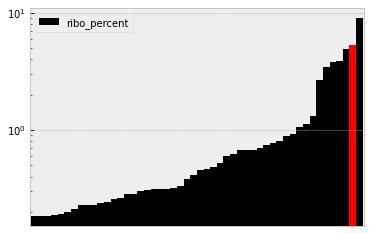

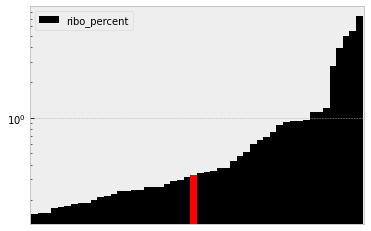

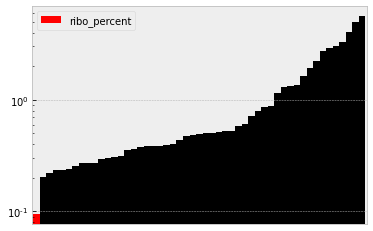

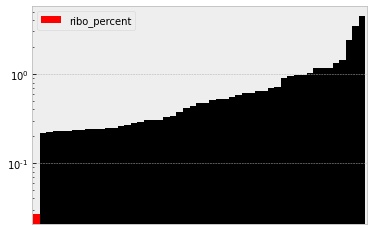

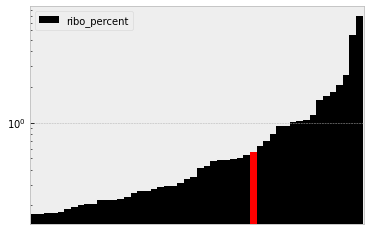

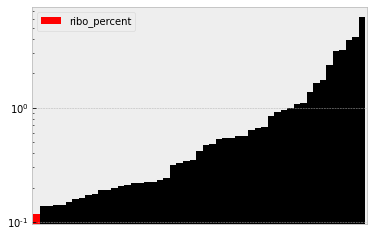

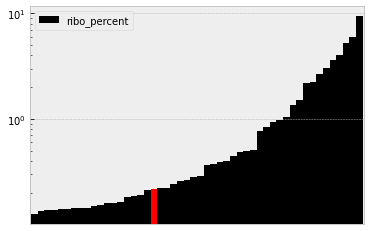

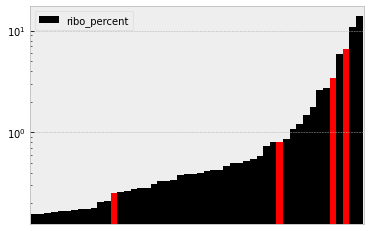

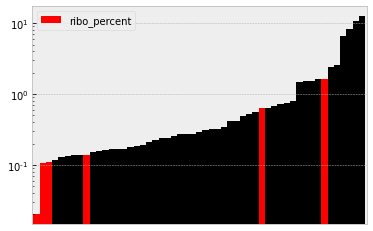

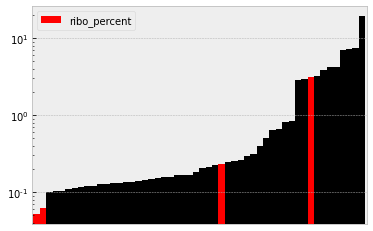

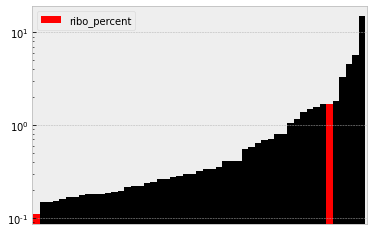

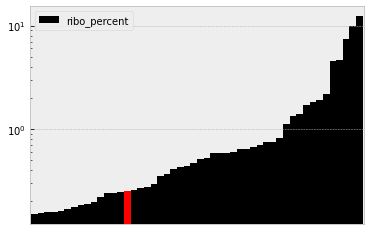

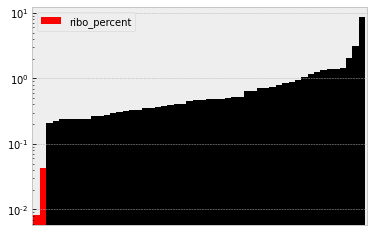

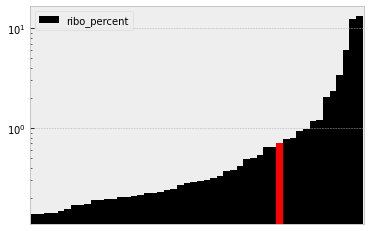

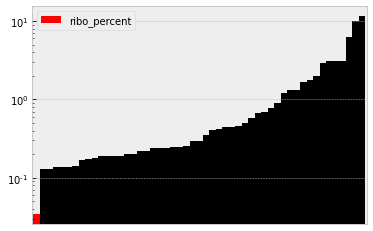

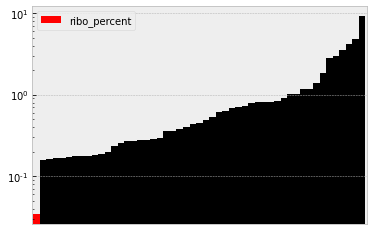

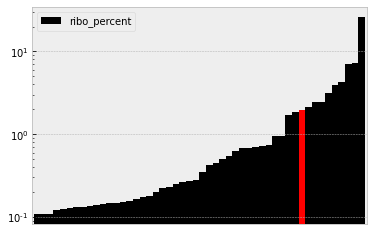

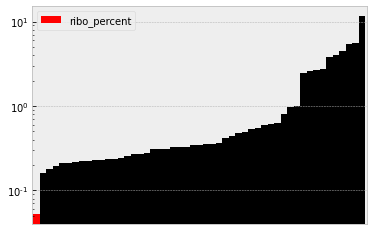

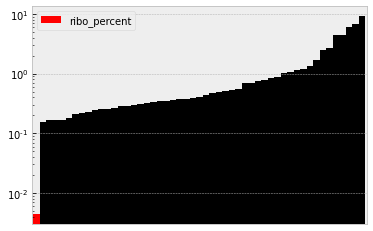

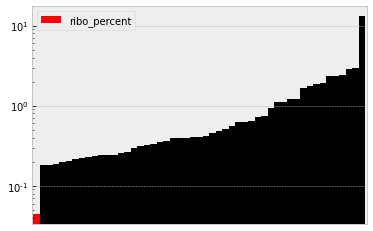

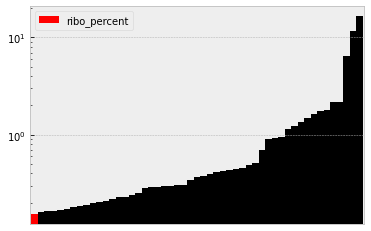

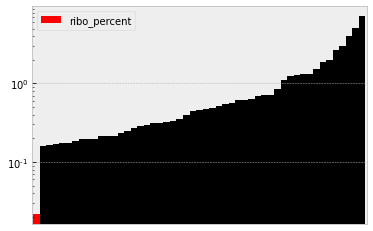

In [401]:
for sample in all_samples:
    make_bar(sample)

In [385]:
plot_bars.head(1)

,file,lib,full_sample,country,donor,rep,ribo_uniq,ribo_size,ribo_seq,ribo_total,ribo_percent,colors
0,046-16S-Hond-16_013-V4-A,16S,Hond_16_013,Hond,16_013,A,uniq_1,3835,GGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGT...,42640,8.993902,black


[]

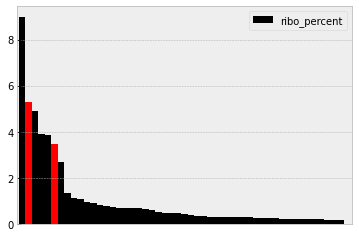

In [386]:
g=plot_bars.plot(kind='bar',x='ribo_uniq', y='ribo_percent', color=plot_bars['colors'], width=1.0) 
#g=best_hit_count.head(200).plot(kind='bar', color=[colors[i] for i in df['Condition']])
g.set(xlabel=None)
#g.set_yscale('log')
g.get_xaxis().set_ticks([])
#plt.savefig(OUT+"figures/uniref_clusters_per_RGI_hit.png")
#plt.savefig(OUT+"figures/uniref_clusters_per_RGI_hit.svg")